# ColPali: how to get similarity maps? 👀

[![Colab](https://img.shields.io/badge/Open_in_Colab-F9AB00?logo=googlecolab&logoColor=fff&style=for-the-badge)](https://colab.research.google.com/github/tonywu71/colpali-cookbooks/blob/main/examples/gen_colpali_similarity_maps.ipynb)
[![GitHub](https://img.shields.io/badge/ColPali_Cookbooks-100000?style=for-the-badge&logo=github&logoColor=white)](https://github.com/tonywu71/colpali-cookbooks)
[![X](https://img.shields.io/badge/Thread-%23000000?style=for-the-badge&logo=X&logoColor=white)](https://x.com/tonywu_71/status/1809183824464560138)

[![arXiv](https://img.shields.io/badge/arXiv-2407.01449-b31b1b.svg?style=for-the-badge)](https://arxiv.org/abs/2407.01449)
[![Hugging Face](https://img.shields.io/badge/Vidore-FFD21E?style=for-the-badge&logo=huggingface&logoColor=000)](https://huggingface.co/vidore)
[![GitHub](https://img.shields.io/badge/ColPali_Engine-100000?style=for-the-badge&logo=github&logoColor=white)](https://github.com/illuin-tech/colpali)
[![GitHub](https://img.shields.io/badge/ViDoRe_Benchmark-100000?style=for-the-badge&logo=github&logoColor=white)](https://github.com/illuin-tech/vidore-benchmark)

## Introduction

> With our new model *ColPali*, we propose to leverage VLMs to construct efficient multi-vector embeddings in the visual space for document retrieval. By feeding the ViT output patches from PaliGemma-3B to a linear projection, we create a multi-vector representation of documents. We train the model to maximize the similarity between these document embeddings and the query embeddings, following the ColBERT method.
>
> ColPali is also highly interpretable: similarity maps can be obtained between patches and query tokens. These maps highlight ColPali’s strong OCR capabilities and chart understanding.

The following notebook guide you through how to generate your own similarity maps. You can run it on Colab or locally (tested on a M2 Pro Mac).

## Login to a HuggingFace account

Because ColPali uses the [PaliGemma3B](https://huggingface.co/google/paligemma-3b-mix-448) checkpoints, you need to accept its terms and conditions before using it. Once accepted, use the following cell to login to your HuggingFace account.

In [1]:
!pip install -q huggingface_hub
from huggingface_hub import notebook_login

notebook_login()

## Imports

In [ ]:
!pip install -q "vidore-benchmark[interpretability]>=4.0.0,<5.0.0"

In [2]:
import pprint
from pathlib import Path
from typing import cast

import torch
from colpali_engine.models import ColPali, ColPaliProcessor
from colpali_engine.utils.torch_utils import get_torch_device
from einops import rearrange
from PIL import Image
from vidore_benchmark.interpretability.plot_utils import plot_similarity_heatmap
from vidore_benchmark.interpretability.torch_utils import (
    normalize_similarity_map_per_query_token,
)
from vidore_benchmark.interpretability.vit_configs import VIT_CONFIG
from vidore_benchmark.utils.image_utils import scale_image


## Load model + adapter + custom processor

In [6]:
model_name = "vidore/colpali-v1.2"
processor_name = "google/paligemma-3b-mix-448"

device = get_torch_device("auto")
print(f"Using device: {device}")

# Load the model
model = cast(
    ColPali,
    ColPali.from_pretrained(
        model_name,
        torch_dtype=torch.bfloat16,
        device_map=device,
    ),
).eval()

# Load the processor
processor = cast(ColPaliProcessor, ColPaliProcessor.from_pretrained(processor_name))

# Load the ViT config
vit_config = VIT_CONFIG[model.config.name_or_path]

Using device: cuda:0


/home/gcpuser/sky_workdir/.venv/lib/python3.10/site-packages/transformers/models/paligemma/configuration_paligemma.py:137: FutureWarning: The `vocab_size` attribute is deprecated and will be removed in v4.44, Please use `text_config.vocab_size` instead.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

## Load image from filepaths

⚠️ First, upload your image in the Google Colab environment, then replace the following variable values with your own.

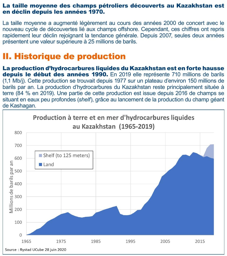

In [13]:
# TODO: Replace the following values with your own!
filepath = Path("shift_kazakhstan.jpg")
query = "Quelle partie de la production pétrolière du Kazakhstan provient de champs en mer ?"

assert filepath.is_file(), f"Cannot find the image file at `{filepath}`"

image = Image.open(filepath)

# Preview the image
scale_image(image, 256)

## Process text and image

In [14]:
# Preprocess inputs
input_text_processed = processor.process_queries([query]).to(device)
input_image_processed = processor.process_images([image]).to(device)

# Forward passes
with torch.no_grad():
    output_text = model.forward(**input_text_processed)
    output_image = model.forward(**input_image_processed)

## Embed text and image separately

In [15]:
# Remove the special tokens from the output
output_image = output_image[:, : processor.image_seq_length, :]  # (1, n_patches_x * n_patches_y, dim)

# Rearrange the output image tensor to explicitly represent the 2D grid of patches
output_image = rearrange(
    output_image, "b (h w) c -> b h w c", h=vit_config.n_patch_per_dim, w=vit_config.n_patch_per_dim
)  # (1, n_patches_x, n_patches_y, dim)

## Per-token similarity map

In [16]:
# Get the similarity map
similarity_map = torch.einsum(
    "bnk,bijk->bnij", output_text, output_image
)  # (1, query_tokens, n_patches_x, n_patches_y)

# Normalize the similarity map
similarity_map_normalized = normalize_similarity_map_per_query_token(
    similarity_map
)  # (1, query_tokens, n_patches_x, n_patches_y)

In [31]:
# Use this cell output to choose a token using its index
query_tokens = processor.tokenizer.tokenize(processor.decode(input_text_processed.input_ids[0]))

pprint.pprint({idx: val for idx, val in enumerate(query_tokens)})

{0: '<bos>',
 1: 'Question',
 2: ':',
 3: '▁Quelle',
 4: '▁partie',
 5: '▁de',
 6: '▁la',
 7: '▁production',
 8: '▁p',
 9: 'étro',
 10: 'lière',
 11: '▁du',
 12: '▁Kazakhstan',
 13: '▁provi',
 14: 'ent',
 15: '▁de',
 16: '▁champs',
 17: '▁en',
 18: '▁mer',
 19: '▁?',
 20: '<pad>',
 21: '<pad>',
 22: '<pad>',
 23: '<pad>',
 24: '<pad>',
 25: '<pad>',
 26: '<pad>',
 27: '<pad>',
 28: '<pad>',
 29: '<pad>',
 30: '\n'}


In [32]:
# Choose a token
token_idx = 12  # e.g. if "12: '▁Kazakhstan',", set 12 to choose the token 'Kazakhstan'

print(f"Token: {processor.batch_decode(input_text_processed.input_ids[:, token_idx])}")

# Retrieve the similarity map for the chosen token
current_similarity_map = similarity_map_normalized[0, token_idx, :, :]

current_similarity_map.shape

Token: [' Kazakhstan']


torch.Size([32, 32])

## Experiment with heatmaps

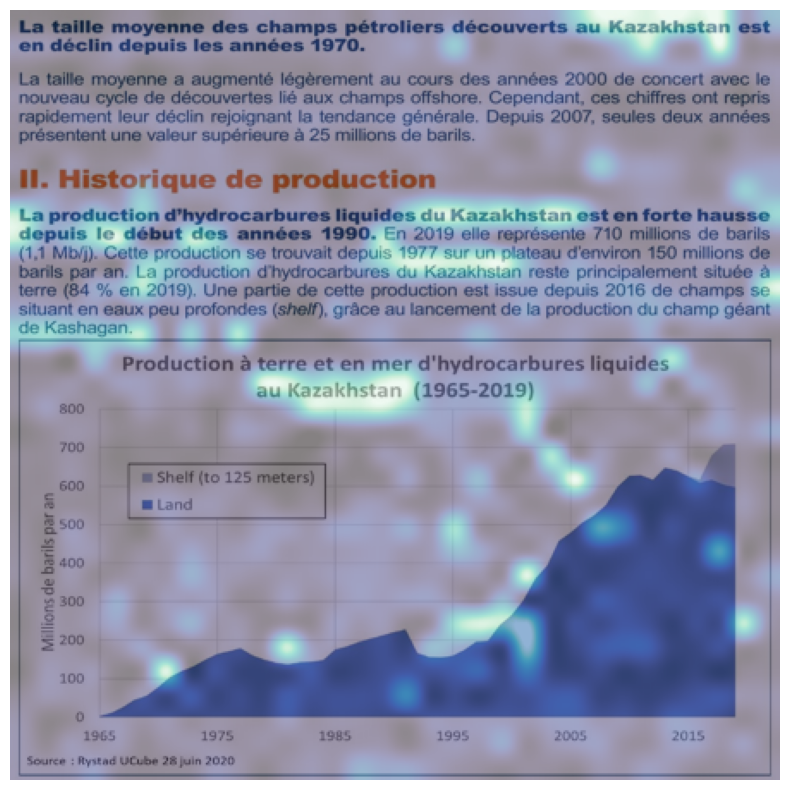

In [36]:
# Resize the image to square
input_image_square = image.resize((vit_config.resolution, vit_config.resolution))

attention_map_image = Image.fromarray(
    (similarity_map_normalized[0, token_idx, :, :].to(torch.float32).cpu().numpy() * 255).astype("uint8")
).resize(input_image_square.size, Image.Resampling.BICUBIC)

# Plot
fig, ax = plot_similarity_heatmap(
    input_image_square,
    patch_size=vit_config.patch_size,
    image_resolution=vit_config.resolution,
    similarity_map=similarity_map_normalized[0, token_idx, :, :],
)